<a href="https://colab.research.google.com/github/AndreassOlsson/drone-anomalydetection/blob/main/UMCD_DataLoader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
import os
import random
import bisect
import tarfile
import pickle
from glob import glob

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn # nn.BCELoss
import torch.optim as optim
import torch.nn.functional as F 
import torch.utils.data as data # data.DataLoader, data.Dataset
import torchvision.transforms as transforms # ToTensor
from tqdm import tqdm


np.random.seed(42)
torch.manual_seed(42)
%matplotlib inline
plt.style.use('ggplot')

In [ ]:
tarfile.open(r'/content/drive/MyDrive/Andreas Olsson/Public-Safety/data/UMCD/umcd-extracted.tgz', 'r:gz').extractall()

## Inspect a video

In [ ]:
def display_frames(video_path=None, cv2_videocapture=None, n_frames=10, starting_frame=0, interval=30, n_cols=5):
  """
  If cv2_videocapture is provided, it overwrites the video_path
  """
  cap = cv2.VideoCapture(video_path) if not cv2_videocapture else cv2_videocapture
  n_frames_total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

  frames = [starting_frame + interval * i for i in range(n_frames) if starting_frame + interval * i <= n_frames_total]
  n_frames = len(frames)

  n_rows = bisect.bisect_right([i for i in range(n_frames) if i % n_cols == 0], n_frames)
  fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3))
  axs = axs.flatten()

  for i, frame in enumerate(frames):
      cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
      res, img = cap.read()
      if res:
          axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
          axs[i].set_title(f'Frame: {frame}')
          axs[i].axis('off')

  plt.tight_layout()
  plt.show()
  cap.release()

def inspect_video(video_path=None, cv2_videocapture=None, df=True, n_frames=10, starting_frame=0, interval=30, n_cols=5):
  cap = cv2.VideoCapture(video_path) if not cv2_videocapture else cv2_videocapture
  fs = cap.get(cv2.CAP_PROP_FRAME_COUNT)
  fps = cap.get(cv2.CAP_PROP_FPS)
  height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
  width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
  print(f'Videospecs:\nFrames {fs}, FPS {fps}, Height {height}, Width {width}')
  print(f'Shape of np array: {cap.read(0)[1].shape}\n')
  if df: display_frames(cv2_videocapture=cap, n_frames=n_frames, starting_frame=starting_frame, interval=interval, n_cols=n_cols)
  else: cap.release()

Videospecs:
Frames 400.0, FPS 49.967, Height 1080.0, Width 1920.0
Shape of np array: (1080, 1920, 3)



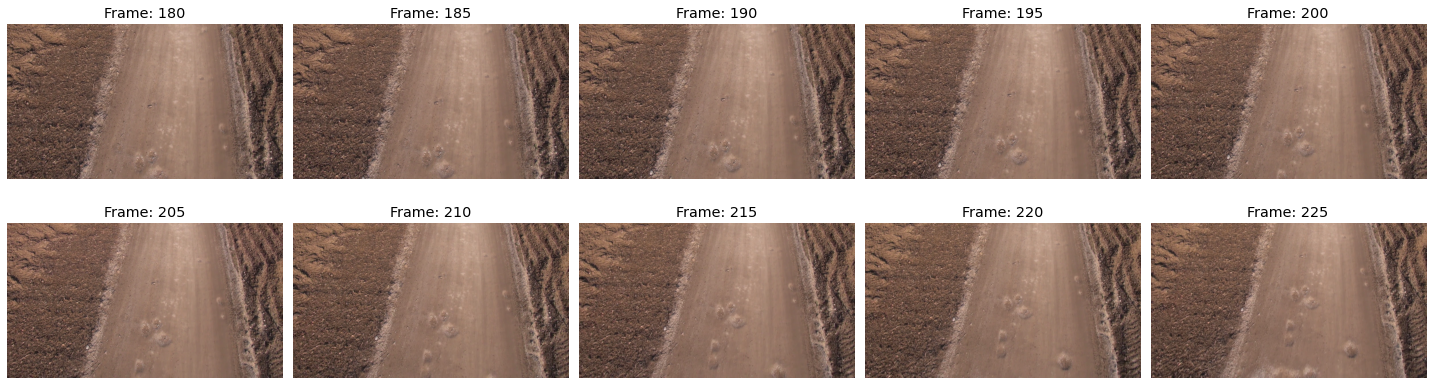

Videospecs:
Frames 799.0, FPS 49.924, Height 1080.0, Width 1920.0
Shape of np array: (1080, 1920, 3)



In [ ]:
inspect_video('/content/umcd-extracted/Normal/Dirt-18-nt.mp4', df=True, starting_frame=180, interval=5)
inspect_video('/content/umcd-extracted/Normal/Dirt-15-nt.mp4', df=False, starting_frame=180, interval=5)

## Create UMCD DataLoaders

In [71]:
class UMCD_video_dset(data.Dataset):
  def __init__(self, video_folder, tfms, target_chw=(3,256,256), n_input_frames=6, n_pred_frames=1):
    self.video_paths = glob(os.path.join(video_folder, '*.mp4'))
    self.tfms, self.target_chw = tfms, target_chw

    self.n_input_frames = n_input_frames
    self.n_pred_frames = n_pred_frames
    self.n = self.n_input_frames + self.n_pred_frames

    self.setup()


  def setup(self):
    frame_intervals = []
    for video_path in self.video_paths:
      cap = cv2.VideoCapture(video_path)
      fs = cap.get(cv2.CAP_PROP_FRAME_COUNT)
      fs = int((fs // self.n) * self.n)

      if len(frame_intervals) == 0: frame_intervals = [fs // self.n]
      else: frame_intervals.append(frame_intervals[-1] + fs // self.n)
      cap.release()

    self.frame_intervals = frame_intervals
    

  def __getitem__(self, batch_idx):
    frame_idxs = list(map(lambda x: x + batch_idx * self.n, range(self.n)))
    video_idx = bisect.bisect_right(self.frame_intervals, batch_idx)
    all_frames = torch.empty(self.n, self.target_chw[0], self.target_chw[1], self.target_chw[2])
    
    cap = cv2.VideoCapture(self.video_paths[video_idx])
    for i, frame_idx in enumerate(frame_idxs):
      tup = cap.read(frame_idx)
      assert tup[0] is not None, 'Failed to extract videoframe from videocapture'
      tfmd_frame = self.tfms(tup[1])
      all_frames[i] = tfmd_frame
    cap.release()

    input_frames, target_frames = all_frames[:self.n_input_frames], all_frames[self.n_input_frames:]
    return (input_frames, target_frames)


  def __len__(self): 
    return self.frame_intervals[-1]


  def show(self, batch_idx=None):
    batch_idx = batch_idx if batch_idx else random.randint(0, self.frame_intervals[-1])
    tup = self.__getitem__(batch_idx)
    input_frames, target_frames = tup[0].numpy(), tup[1].numpy()

    f, axs = plt.subplots(1, self.n, figsize=(self.n*3, 3))

    for i, img in enumerate(input_frames): 
      axs[i].imshow(cv2.cvtColor(img.transpose(1,2,0), cv2.COLOR_BGR2RGB))
      axs[i].set_title(f'Input frame {i+1}')
      axs[i].axis('off')

    for n, img in enumerate(target_frames): 
      i = n + self.n_input_frames
      axs[i].imshow(cv2.cvtColor(img.transpose(1,2,0), cv2.COLOR_BGR2RGB))
      axs[i].set_title(f'Target frame {n+1}')
      axs[i].axis('off')

    plt.tight_layout()
    plt.show()

------------------------------ Dataset succesfully created from video folder /content/umcd-extracted/Normal with length 4617 ------------------------------ 
dset[idx] returns a tuple with two tensors that have the shapes torch.Size([6, 3, 256, 256]) and torch.Size([1, 3, 256, 256]) --> (input_frames, target_frames)

idx stands for a sort of batch index where the same video yields multiple batches of videos with a fixed length. The frames of one batch never overlap into another batch
and therefor we will use torch´s random split for train and test sets!



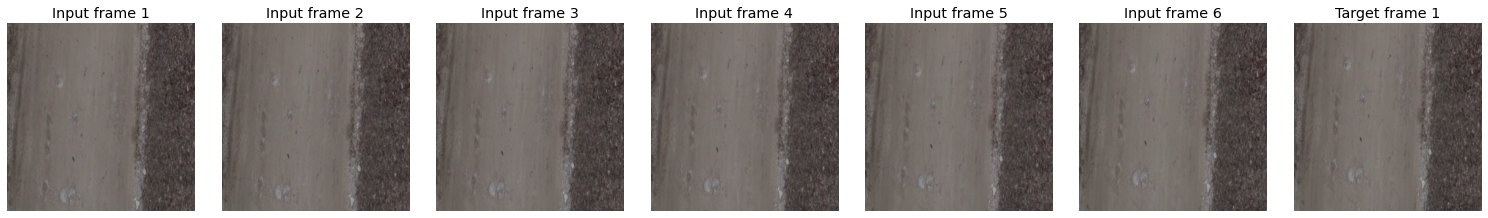

In [88]:
# The training will be on "normal" videos
video_folder = '/content/umcd-extracted/Normal'

# np images are in shape h, w, c
# torch wants images of shape c, h, w
# We need to transform the np arrays to PILImages, then to Tensor etc.
target_chw=(3,256,256)
tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((target_chw[1], target_chw[2])),
    transforms.ToTensor(),
    ])

n_input_frames, n_pred_frames = 6, 1

dset = UMCD_video_dset(video_folder, tfms=tfms, target_chw=target_chw, n_input_frames=n_input_frames, n_pred_frames=n_pred_frames)

idx = random.randint(0, (len(dset)-1))
print('-'*30, f'Dataset succesfully created from video folder {video_folder} with length {len(dset)}', '-'*30, f'\ndset[idx] returns a tuple with two tensors that have the shapes {dset[idx][0].shape} and {dset[idx][1].shape} --> (input_frames, target_frames)\n')
print('idx stands for a sort of batch index where the same video yields multiple batches of videos with a fixed length. The frames of one batch never overlap into another batch\nand therefor we will use torch´s random split for train and test sets!\n')
dset.show()

In [100]:
train_dset, test_dset = data.random_split(dset, [0.7, 0.3], generator=torch.Generator().manual_seed(42))
len(train_dset), len(test_dset)

(3232, 1385)

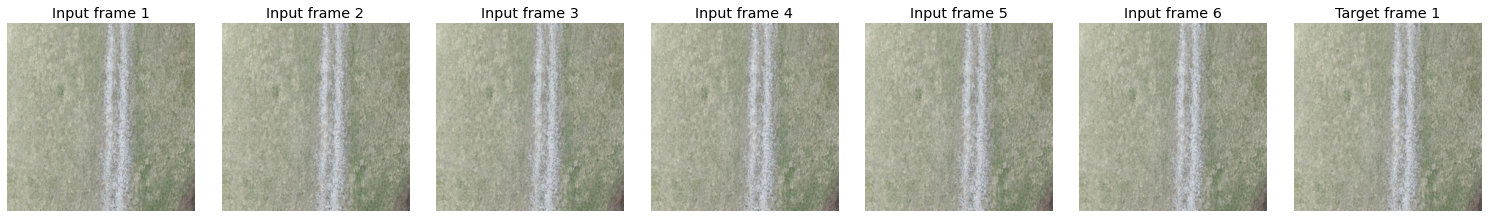

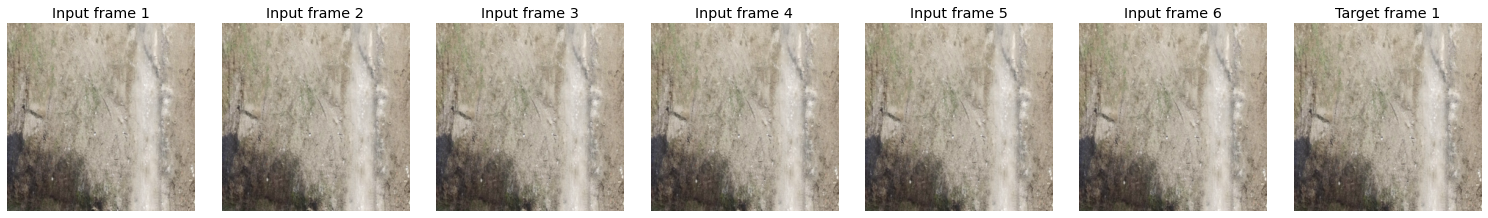

In [105]:
train_dset.dataset.show()
test_dset.dataset.show()

In [112]:
train_dl = data.DataLoader(train_dset.dataset, batch_size = 64, shuffle = True)
test_dl = data.DataLoader(test_dset.dataset, batch_size = 64, shuffle = False)

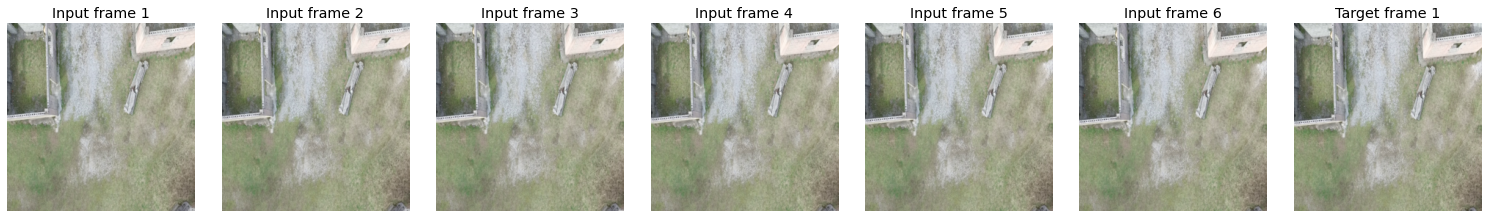

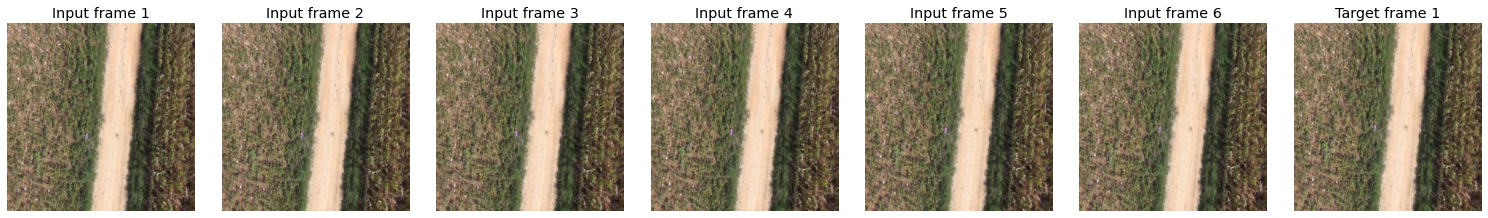

In [118]:
train_dl.dataset.show()
test_dl.dataset.show()

In [119]:
torch.save(train_dl, '/content/drive/MyDrive/Andreas Olsson/Public-Safety/data/UMCD/umcd_train_dataloader.pth')
torch.save(test_dl, '/content/drive/MyDrive/Andreas Olsson/Public-Safety/data/UMCD/umcd_test_dataloader.pth')